In [ ]:
from fore_utils import WeatherData

In [2]:
window_size = 24
steps = 24
spaces = 5
hidden_size = 32
batch_size = 64
series_target = False
verbose = True

# If on lightining AI
lightning = False

# train_set = WeatherData(window_size=window_size, step_size=steps, set='train', spaces=spaces, lightning=lightning, series_target=series_target, verbose=verbose)
    
train_set = WeatherData(window_size=window_size,
                         step_size=steps, 
                         set='val', 
                         spaces=spaces, 
                         lightning=lightning, 
                         series_target=series_target, 
                         verbose=verbose)

dataset_config = {
    "window_size" : [train_set.window_size],
    "step_size" : [train_set.step_size],
    "spaces" : [train_set.spaces],
    "batch_size": [batch_size],
    "series_target": [train_set.series_target]
}


Details for val set:
Data from ['2022'] loaded


Features shape: torch.Size([8760, 6])
Targets shape: torch.Size([8760])
Longitudes: 18.3061580657959
Latitudes: -31.636999130249023


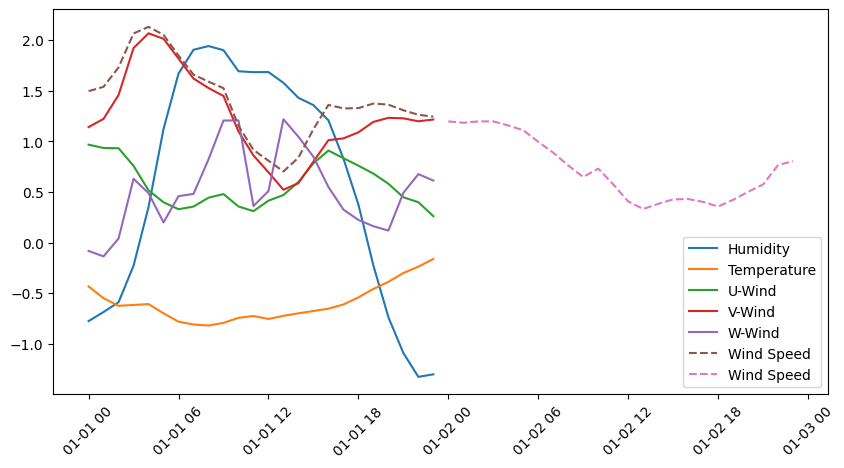

In [3]:
# For spaces = 0
train_set.spaces = 0

train_set.re_init()

train_set.plot_point()

In [4]:
train_set.spaces = 3

train_set.re_init()

train_set.plot_animation()

Features shape: torch.Size([8760, 6, 6, 6])
Targets shape: torch.Size([8760, 6, 6])
Longitudes: [17.556114 17.80613  18.056143 18.306158 18.556171 18.806185]
Latitudes: [-30.887 -31.137 -31.387 -31.637 -31.887 -32.137]


In [4]:
import torch
import torch.nn as nn

# Simple MLP

class MLP_Point(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, variables: int = 6):
        super(MLP_Point, self).__init__()

        input_size = input_size * variables
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x
    
class MLP_Point_Rollout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, variables: int = 6):
        super(MLP_Point_Rollout, self).__init__()

        self.variables = variables

        input_size = input_size * variables
        self.output_size = output_size
        output = variables
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output)
    
    def forward(self, x):
        return self.rollout(x).squeeze()
    
    def step(self, x):
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        
        return x.reshape(x.size(0), -1, self.variables)
    
    def rollout(self, x):
        pred = []
        for i in range(self.output_size):
            y = self.step(x)
            pred.append(y)

            x = torch.cat([x[:,1:], y[:,-1:]], dim=1)

        return torch.stack(pred, dim=1)

class MLP_Spatial(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, spaces, variables: int = 6):
        super(MLP_Spatial, self).__init__()
        self.window_size = input_size

        input_size = input_size * spaces * spaces * 4 * variables
        output_size = output_size * spaces * spaces * 4
        
        self.spaces = spaces * 2
        

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        x = x.reshape(x.size(0),self.window_size, self.spaces, self.spaces)

        return x

In [5]:
from torch.utils.data import DataLoader

# User settings
window_size = 24
steps = 24
spaces = 0
batch_size = 32
series_target = False
all_variables = False
verbose = False

# Class updates
train_set.window_size = window_size
train_set.step_size = steps
train_set.spaces = spaces
train_set.all_variables = all_variables
train_set.series_target = series_target
train_set.verbose = verbose

train_set.re_init()

point_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

model_point = MLP_Point(input_size=window_size, 
                        hidden_size=hidden_size,
                        output_size=steps)

for batch in point_loader:
    x, b, y = batch
    break

print('x: ', x.shape)
print('b: ', b.shape)
print('y: ', y.shape)

y_pred = model_point(x)

print('y_pred: ', y_pred.shape)

x:  torch.Size([32, 24, 6])
b:  torch.Size([32, 24])
y:  torch.Size([32, 24])
y_pred:  torch.Size([32, 24])


torch.Size([32, 24, 6]) torch.Size([32, 24]) torch.Size([32, 24]) torch.Size([32, 24])


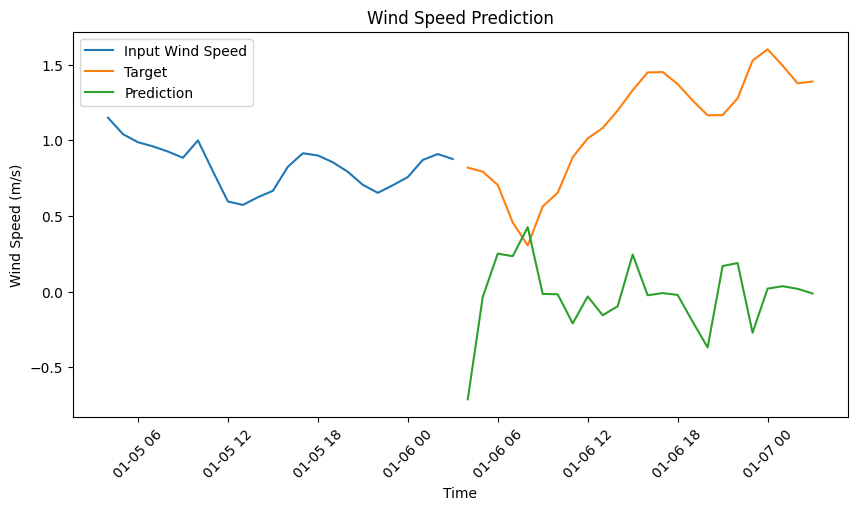

In [6]:
print(x.shape, b.shape, y.shape, y_pred.shape)

train_set.plot_point_pred(model=model_point, seed = 100)

In [7]:

from torch.utils.data import DataLoader

# User settings
window_size = 24
steps = 24
spaces = 0
batch_size = 32
series_target = False
all_variables = True
verbose = False

# Class updates
train_set.window_size = window_size
train_set.step_size = steps
train_set.spaces = spaces
train_set.all_variables = all_variables
train_set.series_target = series_target
train_set.verbose = verbose

train_set.re_init()

point_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

model_point_rollout = MLP_Point_Rollout(input_size=window_size, 
                        hidden_size=hidden_size,
                        output_size=steps)

for batch in point_loader:
    x, b, y = batch
    break

print('x: ', x.shape)
print('b: ', b.shape)
print('y: ', y.shape)

y_pred = model_point_rollout(x)

print('y_pred: ', y_pred.shape)

x:  torch.Size([32, 24, 6])
b:  torch.Size([32, 24])
y:  torch.Size([32, 24, 6])
y_pred:  torch.Size([32, 24, 6])


torch.Size([32, 24, 6]) torch.Size([32, 24]) torch.Size([32, 24, 6]) torch.Size([32, 24, 6])


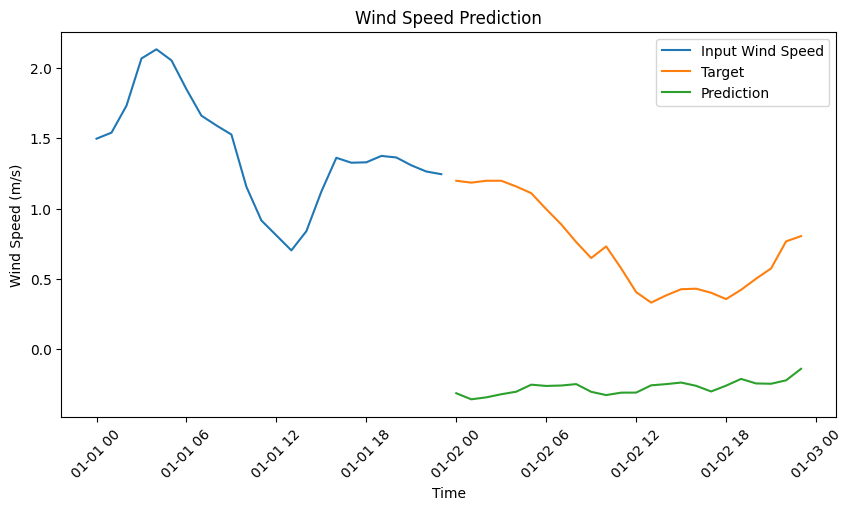

In [11]:
print(x.shape, b.shape, y.shape, y_pred.shape)

train_set.plot_point_pred(model=model_point_rollout, seed = 0, specific=5)

In [14]:
from torch.utils.data import DataLoader

# User settings
window_size = 24
steps = 24
spaces = 4
batch_size = 32
series_target = False
all_variables = False
verbose = False

# Class updates
train_set.window_size = window_size
train_set.step_size = steps
train_set.spaces = spaces
train_set.series_target = series_target
train_set.all_variables = all_variables
train_set.verbose = verbose

train_set.re_init()

spatial_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

model_spatial = MLP_Spatial(input_size=window_size, 
                            hidden_size=hidden_size, 
                            output_size=steps, 
                            spaces=spaces)

for batch in spatial_loader:
    x, b, y = batch
    break

print('Spatial')
print('x: ', x.shape)
print('b: ', b.shape)
print('y: ', y.shape)

out = model_spatial(x)

print('out: ', out.shape)


Spatial
x:  torch.Size([32, 24, 8, 8, 6])
b:  torch.Size([32, 24, 8, 8])
y:  torch.Size([32, 24, 8, 8])
out:  torch.Size([32, 24, 8, 8])


In [15]:
train_set.plot_prediction(model_spatial)

Predictions: (24, 8, 8)
Targets: (24, 8, 8)
